In [1]:
import numpy as np
import os
from shutil import copyfile
import shutil
import matplotlib.pyplot as plt
import cv2
import random
import json
import time
import glob
import math
from pathlib import Path
from tqdm import tqdm
from scipy.io import loadmat
from PIL import Image
import pandas as pd
import csv
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision.transforms.functional as F
from torchvision import transforms
import torchvision.transforms as T

from util import get_transform
from datasets import *
from models import WSDAN_CAL

device = torch.device("cuda:0")

In [2]:

transform = get_transform(resize=(224, 224), phase='val')
dataset = compcars_dataset.CompCars(transform=transform, split='val')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
num_classes = dataset.num_classes
num_classes

431

In [3]:
import configs.config_compcars as config

ckpt = "/mnt/raid/home/eyal_michaeli/git/CAL/fgvc/logs/compcars/2023_1217_1523_02_base-fixed_classes_401/model_bestacc.pth"


net = WSDAN_CAL(num_classes=num_classes, M=config.num_attentions, net=config.net, pretrained=True).to(device)
# Load ckpt and get state_dict
checkpoint = torch.load(ckpt)

# Get epoch and some logs
logs = checkpoint['logs']
start_epoch = int(logs['epoch']) # start from the beginning

# Load weights
state_dict = checkpoint['state_dict']
net.load_state_dict(state_dict)

# load feature center
if 'feature_center' in checkpoint:
    feature_center = checkpoint['feature_center'].cuda()
    print("Loading feature center with size:", feature_center.size())


==> using resnet with stride= 16
ResNet: All params loaded
WSDAN_CAL: Some params were not loaded:
fc.weight


In [7]:
from collections import defaultdict

# Initialize counters
make_correct = defaultdict(int)
model_correct = defaultdict(int)
make_total = defaultdict(int)
model_total = defaultdict(int)

net.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader)):
        # if i == 100:
        #     break
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs, _, __, ___ = net(images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update make and model counters
        for label, pred in zip(labels, predicted):
            label_make = dataset.class_id_to_car_make_map[label.item()]
            label_model = dataset.class_id_to_car_model_map[label.item()]
            pred_make = dataset.class_id_to_car_make_map[pred.item()]
            pred_model = dataset.class_id_to_car_model_map[pred.item()]

            make_total[label_make] += 1
            model_total[label_model] += 1
            
            if label_make == pred_make:
                make_correct[label_make] += 1

            if label_model == pred_model:
                model_correct[label_model] += 1
            


4255it [01:54, 37.22it/s]


Overall Accuracy (including year): 89.847 %


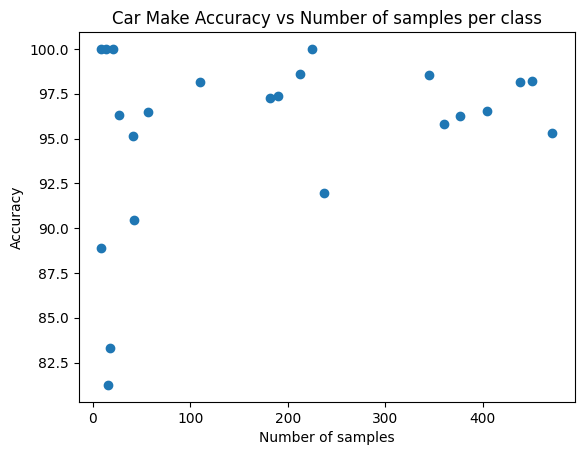

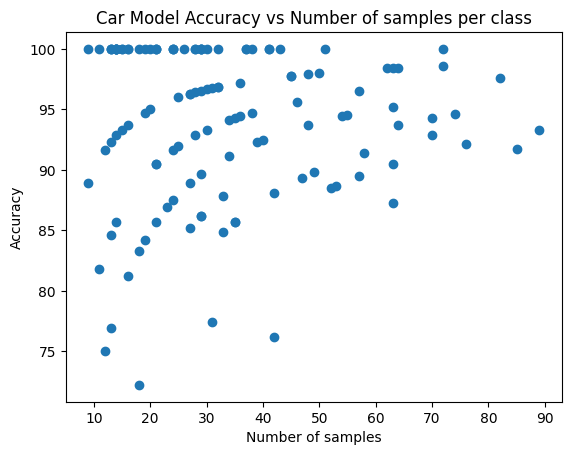

Accuracy for make 69: 97.253 % num_samples: 182
Accuracy for make 122: 95.833 % num_samples: 360
Accuracy for make 114: 97.368 % num_samples: 190
Accuracy for make 53: 98.592 % num_samples: 213
Accuracy for make 160: 98.182 % num_samples: 110
Accuracy for make 54: 98.174 % num_samples: 438
Accuracy for make 102: 98.222 % num_samples: 450
Accuracy for make 158: 98.551 % num_samples: 345
Accuracy for make 15: 100.000 % num_samples: 225
Accuracy for make 157: 95.329 % num_samples: 471
Accuracy for make 162: 96.277 % num_samples: 376
Accuracy for make 108: 91.983 % num_samples: 237
Accuracy for make 97: 96.535 % num_samples: 404
Accuracy for make 51: 96.491 % num_samples: 57
Accuracy for make 120: 96.296 % num_samples: 27
Accuracy for make 128: 100.000 % num_samples: 14
Accuracy for make 155: 90.476 % num_samples: 42
Accuracy for make 58: 95.122 % num_samples: 41
Accuracy for make 119: 100.000 % num_samples: 21
Accuracy for make 138: 81.250 % num_samples: 16
Accuracy for make 84: 83.333 % 

In [11]:
# Overall accuracy
print('Overall Accuracy (including year): %.3f %%' % (100 * correct / total))


# plot num samples per class vs accuracy, for car make
x = []
y = []
for make in make_total:
    x.append(make_total[make])
    y.append(100 * make_correct[make] / make_total[make])

plt.scatter(x, y)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('Car Make Accuracy vs Number of samples per class')
plt.show()

# plot num samples per class vs accuracy, for car model
x = []
y = []
for model in model_total:
    x.append(model_total[model])
    y.append(100 * model_correct[model] / model_total[model])
plt.scatter(x, y)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('Car Model Accuracy vs Number of samples per class')
plt.show()


# Accuracy for each make
for make in make_total:
    accuracy = 100 * make_correct[make] / make_total[make]
    print('Accuracy for make %s: %.3f %%' % (make, accuracy), "num_samples:", make_total[make])

# Total accuracy for all makes
total_make_correct = sum(make_correct.values())
total_make_instances = sum(make_total.values())
total_make_accuracy = 100 * total_make_correct / total_make_instances
print('Accuracy for car makes: %.3f %%' % total_make_accuracy)
print()

# Accuracy for each model
for model in model_total:
    accuracy = 100 * model_correct[model] / model_total[model]
    print('Accuracy for model %s: %.3f %%' % (model, accuracy), "num_samples:", model_total[model])

# Total accuracy for all models
total_model_correct = sum(model_correct.values())
total_model_instances = sum(model_total.values())
total_model_accuracy = 100 * total_model_correct / total_model_instances
print('Accuracy for all models: %.3f %%' % total_model_accuracy)


